# Introduction

In this Jupyter Notebook we importing the ENTSO-E Actual Generation per Type data (processed with OPSD time series script) and correcting the hourly data with reported yearly values from ENTSO-E statistical factsheet.

The OPSD time series script converts all data to one resolution (1 hour) and interpolate gaps in the datat set with a max length of 2 hours. 

# Script setup

In [1]:
import numpy as np
import pandas as pd

#Helpers
import os
import glob
from datetime import datetime, date, timedelta, time


#Ploting
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]

# Data directory preparention

Create input, processed and output folders if they don't exist. If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final data

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

sources_yaml_path = os.path.join('input', 'sources.yml')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preparation

1. ENTSO-E Transparency Platform, Actual Generation per Type Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show (accessed on Oct 02, 2020).
 - Proccesed with OPSD time series scrips (own version INETCH)
 time_series_60min_stacked.csv
 
2. ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV) format
https://zenodo.org/record/3461691


Original data: ENTSO-E statistics Available online:
https://www.entsoe.eu/publications/statistics-and-data/#statistical-factsheet

 File - > entsoe-statistical-factsheet-2018-stacked



Previously we used the Energy Balances in the MS Excel file format (2020 edition) eurostat https://ec.europa.eu/eurostat/de/web/energy/data/energy-balances (accessed on Oct 02, 2020). The Energy Balance data only provides gross electricity data.

# Load data functions

In [3]:
def load_timeseries_opsd(fn):
    """
    Read data from OPSD time-series package own modification.

    Parameters
    ----------
    years : None or slice()
        Years for which to read load data
        
    fn : file name or url location (file format .csv)
    
    countries : Countries for which to read load data.
        
    Returns
    -------
    load : pd.DataFrame
        Load time-series with UTC timestamps x ISO-2 countries
    """

     
    generation = pd.read_csv(fn, index_col='utc_timestamp', parse_dates=True) #, header=[0, 1, 2, 3, 4, 5], parse_dates=True)
                    #.dropna(how="all", axis=0)  
        
    #generation.columns = generation.columns.droplevel(level=[2,3,4,5])
    #generation = generation[~generation['region'].str.contains("_")]

    generation = generation.drop(columns='attribute')
    
    return generation

def load_stats_factsheet(path, fn):
    """
    Load the ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV).
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),index_col=[0], header=[0, 1], parse_dates=True)
    
    return generation

In [4]:
def convert_ENTSOE_to_INATECH_type(ProductionTypeName):
    """
    Converts ENTSO-E Generation per Type source names into INATECH technology type names.

    Parameters
    ----------
    ProductionTypeName : string
        ENTSO-E name of production type.

    Returns
    -------
    string
        INATECH names of production type.

    """

    return ProductionTypeName.replace({
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}, inplace=False)

# Load and filter data¶

In [5]:
# period filter
start = '2018-01-01 00:00:00+00:00'
end = '2018-12-31 23:00:00+00:00'

## load data timeseries_opsd

In [6]:
# load data
entsoe_gen_type = load_timeseries_opsd(fn=input_directory_path + '/time_series_60min_stacked.csv')

In [7]:
entsoe_gen_type = entsoe_gen_type.loc[start:end].copy()

In [8]:
# show the data set
entsoe_gen_type

,region,variable,data
utc_timestamp,,,
2018-01-01 00:00:00+00:00,AT,Biomass,316.0
2018-01-01 01:00:00+00:00,AT,Biomass,316.0
2018-01-01 02:00:00+00:00,AT,Biomass,316.0
2018-01-01 03:00:00+00:00,AT,Biomass,316.0
2018-01-01 04:00:00+00:00,AT,Biomass,316.0
...,...,...,...
2018-12-31 19:00:00+00:00,SK,Solar,0.4
2018-12-31 20:00:00+00:00,SK,Solar,0.2
2018-12-31 21:00:00+00:00,SK,Solar,0.2


## load and standardize data Stats FACT

In [9]:
# load data
entsoe_stats = load_stats_factsheet(input_directory_path, 'Stats_FACT_table.csv')

In [10]:
# show the data set
entsoe_stats

country         AL                                                         \
source     biomass  gas hard_coal      hydro lignite nuclear other_fossil   
year                                                                        
2018-01-01     0.0  0.0       0.0  8100000.0     0.0     0.0          0.0   

country                                 ...          TR              \
source     other_renewable solar waste  ...   hard_coal       hydro   
year                                    ...                           
2018-01-01             0.0   0.0   0.0  ...  67800000.0  59800000.0   

country                                                                       \
source         lignite nuclear other_fossil other_renewable      solar waste   
year                                                                           
2018-01-01  44800000.0     0.0    1400000.0       6900000.0  7200000.0   0.0   

country                                
source     wind_offshore wind_onshore  
year                                   
2018-01-01           0.0   19900000.0  

[1 rows x 432 columns]

## standardize data

In [11]:
# available countries in entsoe stats data set
countries = entsoe_stats.columns.levels[0].to_list()

In [12]:
countries

['AL',
 'AT',
 'BA',
 'BE',
 'BG',
 'CH',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'ES',
 'FI',
 'FR',
 'GB',
 'GR',
 'HR',
 'HU',
 'IE',
 'IS',
 'IT',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK',
 'TR']

In [13]:
entsoe_gen_type.region.unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DE_50hertz', 'DE_LU',
       'DE_amprion', 'DE_tennet', 'DE_transnetbw', 'DK', 'DK_1', 'DK_2',
       'DK_energinet', 'EE', 'ES', 'FI', 'FR', 'GB_GBN', 'GB_NIR',
       'GB_UKM', 'GR', 'HU', 'IE', 'IE_sem', 'IT', 'IT_BRNN', 'IT_CNOR',
       'IT_CSUD', 'IT_FOGN', 'IT_NORD', 'IT_PRGP', 'IT_ROSN', 'IT_SARD',
       'IT_SICI', 'IT_SUD', 'LT', 'LV', 'ME', 'NL', 'NO', 'NO_1', 'NO_2',
       'NO_3', 'NO_4', 'NO_5', 'PL', 'PT', 'RO', 'RS', 'SE', 'SE_1',
       'SE_2', 'SE_3', 'SE_4', 'SI', 'SK'], dtype=object)

In [14]:
# replace region GB_UKM with GB
entsoe_gen_type.region = entsoe_gen_type.region.replace({'GB_UKM' : 'GB'})

In [15]:
# filter entso e data
entsoe_gen_type.query('region in @countries', inplace= True)

In [16]:
entsoe_gen_type.variable.unique()

array(['Biomass', 'Fossil Gas', 'Fossil Hard coal', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Other', 'Solar', 'Waste', 'Wind Onshore',
       'Fossil Oil', 'Nuclear', 'Wind Offshore',
       'Fossil Brown coal/Lignite', 'Fossil Coal-derived gas',
       'Other renewable', 'Fossil Peat'], dtype=object)

In [17]:
# change ProductionTypeNames into INATECH technology type names
entsoe_gen_type.variable = convert_ENTSOE_to_INATECH_type(entsoe_gen_type.variable)

In [18]:
entsoe_gen_type.variable.unique()

array(['biomass', 'gas', 'hard_coal', 'other_renewable', 'hydro',
       'other_fossil', 'solar', 'waste', 'wind_onshore', 'nuclear',
       'wind_offshore', 'lignite'], dtype=object)

In [19]:
# after changing the production type we need to group the dataset
# reset index for groupby function
entsoe_gen_type.reset_index(inplace=True)
# group same production types
entsoe_gen_type = entsoe_gen_type.groupby(['variable', 'utc_timestamp','region']).sum()
# set the old index for the dataframe
entsoe_gen_type = entsoe_gen_type.reset_index().set_index('utc_timestamp')

In [20]:
# show the head of the data set 
entsoe_gen_type.head(10)

,variable,region,data
utc_timestamp,,,
2018-01-01 00:00:00+00:00,biomass,AT,316.00
2018-01-01 00:00:00+00:00,biomass,BE,232.46
2018-01-01 00:00:00+00:00,biomass,BG,28.00
2018-01-01 00:00:00+00:00,biomass,CZ,261.78
2018-01-01 00:00:00+00:00,biomass,DE,4764.00
2018-01-01 00:00:00+00:00,biomass,DK,587.00
2018-01-01 00:00:00+00:00,biomass,EE,71.10
2018-01-01 00:00:00+00:00,biomass,ES,275.00
2018-01-01 00:00:00+00:00,biomass,FI,855.71


In [21]:
# convert entso data into table format
entsoe_gen_type_table =  pd.pivot_table(entsoe_gen_type, values='data', index=entsoe_gen_type.index, columns=['region','variable'])

In [22]:
entsoe_gen_type_table.head()

region                         AT                                       \
variable                  biomass   gas hard_coal   hydro other_fossil   
utc_timestamp                                                            
2018-01-01 00:00:00+00:00   316.0  71.0     150.0  3345.0         22.0   
2018-01-01 01:00:00+00:00   316.0  70.0     149.0  3275.0         22.0   
2018-01-01 02:00:00+00:00   316.0  69.0     149.0  3167.0         22.0   
2018-01-01 03:00:00+00:00   316.0  72.0     149.0  3160.0         22.0   
2018-01-01 04:00:00+00:00   316.0  75.0     149.0  3330.0         22.0   

region                                                                   BE  \
variable                  other_renewable solar  waste wind_onshore biomass   
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00             0.0   0.0  100.0        832.0  232.46   
2018-01-01 01:00:00+00:00             0.0   0.0  100.0        926.0  153.58   
2018-01-01 02:00:00+00:00             0.0   0.0  100.0        692.0  133.70   
2018-01-01 03:00:00+00:00             0.0   0.0  100.0        453.0  131.38   
2018-01-01 04:00:00+00:00             0.0   0.0  100.0        321.0  131.26   

region                     ...           SI      SK                           \
variable                   ... wind_onshore biomass    gas hard_coal   hydro   
utc_timestamp              ...                                                 
2018-01-01 00:00:00+00:00  ...         0.70    28.2  175.6      48.1  455.93   
2018-01-01 01:00:00+00:00  ...         0.61    28.1  172.9      48.0  461.95   
2018-01-01 02:00:00+00:00  ...         0.57    28.1  162.1      46.7  513.39   
2018-01-01 03:00:00+00:00  ...         0.62    29.7  140.3      45.3  587.83   
2018-01-01 04:00:00+00:00  ...         0.56    29.5  143.5      46.4  562.89   

region                                                                        
variable                  lignite nuclear other_fossil other_renewable solar  
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00   179.5  1819.3        478.8            41.4   0.0  
2018-01-01 01:00:00+00:00   177.9  1816.7        475.8            41.0   0.0  
2018-01-01 02:00:00+00:00   174.7  1808.7        469.5            40.8   0.0  
2018-01-01 03:00:00+00:00   168.5  1803.6        455.6            39.4   0.0  
2018-01-01 04:00:00+00:00   170.6  1809.1        461.5            40.4   0.0  

[5 rows x 214 columns]

## Scaling entsoe generation data

In [23]:
# zwei Möglichkeiten zu skalieren
#1 skaliere nur, wenn der Wert in Quelle größer 0 ist und großer als im zu skalierenden Datensatz ist. Sonst überspringe und skaliere nicht.
#2 skaliere alles nach FACT Sheet
scaling_option = 1

In [24]:
countries = entsoe_gen_type_table.columns.levels[0].to_list()

In [25]:
def normed(x): return x.divide(x.sum())

if scaling_option == 1:  

    entso_scaled = entsoe_gen_type_table.copy()

    for country in countries:
        for i in entso_scaled[country]:
            try:
                if entsoe_stats[country].at['2018',i] == 0:
                    pass
                    print('stats = 0 ' + country + ' ' +i)
                elif entsoe_stats[country].at['2018',i] < entso_scaled[(country,i)].sum(): 
                    pass
                    print('entso-e > ' + country + ' ' +i)
                else:
                    entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
            except KeyError:
                pass
                print('KeyErros ' + country + ' ' +i)

elif scaling_option == 2:

    entso_scaled = entsoe_gen_type_table.copy()
    
    for country in countries:
        for i in entso_scaled[country]:
            if entsoe_stats[country].at['2018',i] == 0:
                pass
                print(country + ' ' +i)
            else:
                try:
                    entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
                except KeyError:
                    pass
                    print(country + ' ' +i)

else:                    
    pass
    print('Select one of the available scaling options')

stats = 0 AT biomass
stats = 0 AT solar
stats = 0 AT waste
entso-e > AT wind_onshore
entso-e > BE gas
entso-e > BE nuclear
entso-e > BE other_fossil
entso-e > BE solar
entso-e > BE waste
entso-e > BG gas
entso-e > BG hard_coal
entso-e > BG lignite
entso-e > BG nuclear
stats = 0 BG waste
entso-e > CH nuclear
entso-e > CY wind_onshore
entso-e > CZ hard_coal
entso-e > CZ hydro
entso-e > CZ other_fossil
stats = 0 CZ other_renewable
entso-e > CZ solar
stats = 0 CZ waste
entso-e > CZ wind_onshore
entso-e > DE biomass
entso-e > DE hydro
entso-e > DE other_fossil
entso-e > DE solar
entso-e > DE wind_offshore
entso-e > DE wind_onshore
entso-e > DK biomass
entso-e > DK gas
entso-e > DK other_fossil
stats = 0 DK waste
entso-e > DK wind_onshore
stats = 0 EE gas
stats = 0 EE other_renewable
stats = 0 EE solar
stats = 0 EE waste
entso-e > EE wind_onshore
entso-e > ES hard_coal
entso-e > ES hydro
entso-e > ES nuclear
entso-e > ES waste
entso-e > FI gas
entso-e > FI hard_coal
entso-e > FI other_fossil

## Check scaling

In [26]:
country = 'NL'

In [27]:
entsoe_gen_type_table[country].sum()

variable
biomass            239753.0
gas              36625468.0
hard_coal        10887558.0
nuclear           3571693.0
other_fossil      7770123.0
solar             2130133.0
waste              329325.0
wind_offshore     3574250.0
wind_onshore      5644886.0
dtype: float64

In [28]:
entsoe_gen_type_table[country].sum().sum()

70773189.0

In [29]:
entso_scaled[country].sum()/1000000

variable
biomass           3.500000
gas              71.400000
hard_coal        16.700000
nuclear           3.571693
other_fossil      7.770123
solar             3.100000
waste             0.329325
wind_offshore     3.574250
wind_onshore      7.400000
dtype: float64

In [30]:
entso_scaled[country].sum().sum()

117345391.00000045

In [31]:
entsoe_stats[country].sum()

source
biomass             3500000.0
gas                71400000.0
hard_coal          16700000.0
hydro                100000.0
lignite                   0.0
nuclear             2800000.0
other_fossil              0.0
other_renewable           0.0
solar               3100000.0
waste                     0.0
wind_offshore       3500000.0
wind_onshore        7400000.0
dtype: float64

In [32]:
entsoe_stats[country].sum().sum()

108500000.0

In [33]:
GE_compar = pd.DataFrame()

In [34]:
GE_compar.columns

Index([], dtype='object')

In [35]:
GE_compar = entsoe_gen_type_table.sum().reset_index().groupby('region').sum()

In [36]:
GE_compar['ENTSO_E_Generation_scaled'] = entso_scaled.sum().reset_index().groupby('region').sum()

In [37]:
GE_compar['diff'] = GE_compar['ENTSO_E_Generation_scaled'] - GE_compar[0]
GE_compar['diff_pro'] = (100 / GE_compar[0]) * GE_compar['diff']

#CI_compar['diff_bottom_up_vs_CI_1_top_down'] = CI_compar['CI_bottom_up'] - CI_compar['CI_1_top_down']
#CI_compar['diff_pro_1'] = round((100 / CI_compar['CI_bottom_up']) * CI_compar['diff_bottom_up_vs_CI_1_top_down'])

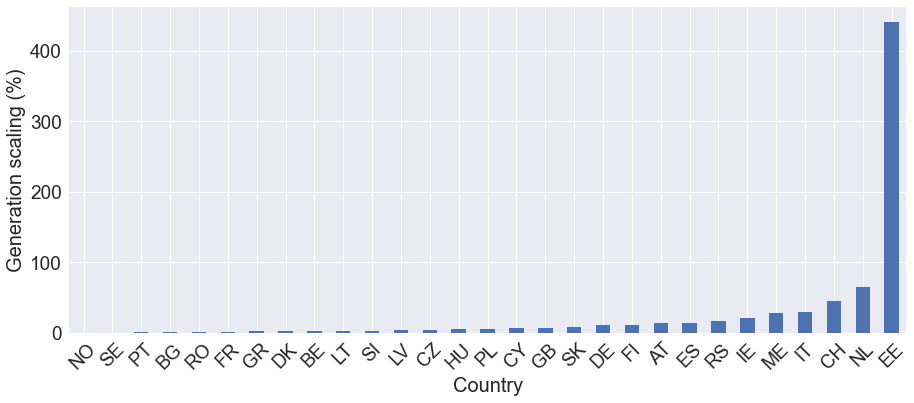

In [38]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 2).sort_values(by='diff_pro')['diff_pro'].plot(kind='bar', ylabel='Generation scaling (%)')

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("Generation scaling (%)", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)


ax.tick_params(axis='x', rotation=45)

In [39]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling.png'))

(0.0, 80.0)

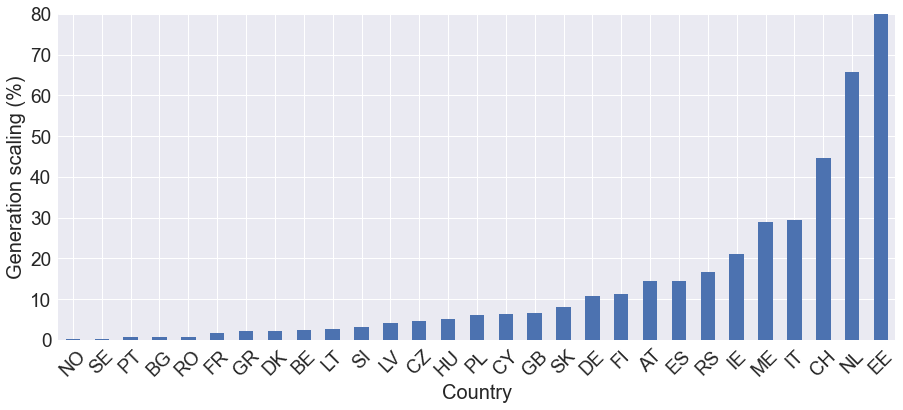

In [40]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 2).sort_values(by='diff_pro')['diff_pro'].plot(kind='bar', ylabel='Generation scaling (%)')

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("Generation scaling (%)", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)


ax.tick_params(axis='x', rotation=45)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(0, 80)  # most of the data

In [41]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling_zoom.png'))

# Export datasets

In [42]:
entsoe_gen_type.to_csv(output_directory_path + '/entsoe_gen_type_hourly.csv')

In [43]:
entsoe_gen_type_table.to_csv(output_directory_path + '/entsoe_gen_type_hourly_table.csv')

In [44]:
entso_scaled.to_csv(output_directory_path + '/entsoe_gen_type_hourly_table_scaled.csv')

# Export tech Dic

In [45]:
dic = {
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}

In [46]:
pd.DataFrame.from_dict(dic, columns=['B'], orient='index').to_csv(output_directory_path + '/entso_gen_type_dic.csv')